<a href="https://colab.research.google.com/github/nianlonggu/Tensorflow-Notebooks/blob/master/pytorch_basic_implemetation_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')
import os; os.chdir("/content/drive/My Drive/Project/NMT")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data preprocessing

In [0]:
MAX_LEN = 100

### load the raw data and convert them first into a dataframe and then into a .csv file for future processing

In [0]:

import pandas as pd


## read file into sentence lists
europarl_de = open( "data/de-en/europarl-v7.de-en.de", encoding = "utf-8" ).read().split("\n")
europarl_en = open( "data/de-en/europarl-v7.de-en.en", encoding = "utf-8" ).read().split("\n")

raw_data = { "German": europarl_de , "English":  europarl_en   }
df = pd.DataFrame( raw_data, columns=[ "German", "English" ] )

## add two more columns to te data frame
df["de_len"] = df["German"].str.count(" ")
df["en_len"] = df["English"].str.count(" ")
## based on added two columns, filter out the src and target sentence which is too long or the length of both differs very much
df = df.query( "de_len < %d & en_len< %d"%(MAX_LEN*0.15, MAX_LEN*0.15) )
df = df.query( "de_len < en_len * 1.5 & en_len < de_len * 1.5"  )


## Split the dataset into training and validation, and save them into csv files
from sklearn.model_selection import train_test_split
train, val = train_test_split( df, test_size = 0.1 )

train.to_csv("train.csv", index=False)
val.to_csv("val.csv", index = False)

In [0]:
train.shape

(377024, 4)

### based on the train.csv and val.csv, first create Field entity to tokenize a certain field in the dataframe, and then use this Field to create a Tabular Dataset 

In [0]:
!python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [0]:
import spacy
import torchtext
from torchtext import data, datasets
from  torchtext.data import Field, BucketIterator, TabularDataset

en = spacy.load("en")
de = spacy.load("de")

def tokenize_en(s):
    return [ tok.text for tok in en.tokenizer(s)]
def tokenize_de(s):
    return [tok.text for tok in de.tokenizer(s)]


DE_Field = Field( tokenize = tokenize_de )
## The Deutsch is the input language, so we do not need to add the SOS and EOS token
EN_Field = Field( tokenize = tokenize_en, init_token = "<sos>", eos_token = "<eos>")
## here we want to train a DE to EN translator, so we need add SOS and EOS to the English vocabulary

## get the train val dataset
train, val = TabularDataset.splits(path="./", train="train.csv", validation= "val.csv", format="csv", \
                                   fields= [ ("German", DE_Field ), ("English", EN_Field) ]   )

## build vocabulary to each field in the dataframe
DE_Field.build_vocab( train, val )
EN_Field.build_vocab( train, val )

### design a "smart" Iterator which is able to fetch a mini batch in which the sentence lengths are similar, and the batch size can also be dynamically updated based on the seq length of current batch, so as to utilize the GPU RAM in a more efficient way.

In [0]:
import torch
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    """Keep augmenting batch and calculate total number of tokens + padding."""
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.German))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.English) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)
class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))
                
                


cuda:0


In [0]:
## Here this batch size is actually the roughly total number of tokens for one batch
train_iter = MyIterator(train, batch_size=2000, device=None,
                        repeat=False, sort_key= lambda x:
                        (len(x.German), len(x.English)),
                        batch_size_fn=batch_size_fn, train=True,
                        shuffle=True)
test_iter = MyIterator( val, batch_size=2000, device=None,
                        repeat=False, sort_key= lambda x:
                        (len(x.German), len(x.English)),
                        batch_size_fn=batch_size_fn, train=False,
                        shuffle=True)

In [0]:
batch =next(iter(train_iter))
print(batch.German.shape)
print(batch.German[:,:10])

torch.Size([12, 153])
tensor([[   13,  1216,    27,     9,    39,    13,     9,    36, 13067,    20],
        [   76,    30,    67,    75,  4816,   153,   934,     6,     7,   111],
        [   11,     4,     4,   123,    41,     3,   679,   393, 17275,    83],
        [   51,  2039, 38375,   141,   165,    16,   512, 14640,    26,    38],
        [   14,    10,  2602,   681,   122,     8,  8212,     7, 19200,    80],
        [ 2658,   101,     7,     3,    15,    14,    59,   136,     7,    84],
        [16552,   654,     4,   925,   154,   839,   300,   428,  1335,   720],
        [    3,   232,  1128,     2,   189, 61369,    37,     3,  2225,  3616],
        [  130,    14,  6055,  1761,     3,  3169,    69,    96,   135,   103],
        [   40,  8895,  1394,     3,    33,    10,  4109,    10,  3981,   689],
        [  665,   402,  2611,   121,   131,    28,   713,  2626,  2058,   800],
        [    2,     2,     2,     2,     2,     2,     2,     2,     2,     2]])


Now we have already have the dataloader which enable us to fetch a batch of src and tgt data. Note:<br>
1) the batch size and sequence length for each batch is not fixed, while the total number of tokens in one batch is roughly the "batch_size" parameter in MyIterator <br>
2) for each batch, the shape of next(iter(train_iter)) is [ sequence_length, batch_size ], so in the design of Transformer, we need to transpose it when get the word embedding.



## Transformer design

In [0]:
import torch.nn as nn
import math
import numpy as np

## for display some figures
from IPython.display import Image

SRC_PAD_INDEX = DE_Field.vocab.stoi["<pad>"]
TGT_PAD_INDEX = EN_Field.vocab.stoi["<pad>"]

In pytorch the Tensor is more like a ndarray, when we give it a ndarray value, it will immediately load it. In tensorflow instead, we need to define a placeholder, and first construct a static computation graph, and we can only pass real data to the placeholder during runing the model.

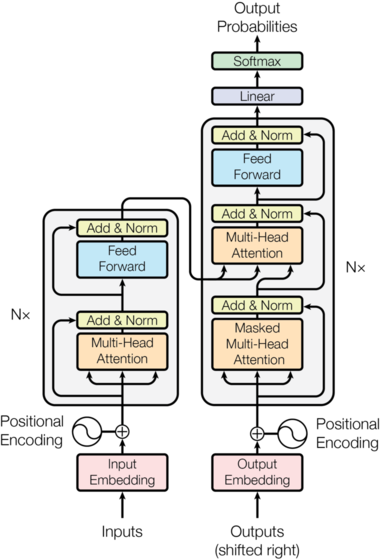

In [0]:
Image("images/Transformer.png")

Figure comes from [How to code The Transformer in Pytorch](https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec#d554) and the original paper [Attention is all you need](https://arxiv.org/abs/1706.03762)

### Positional Encoding

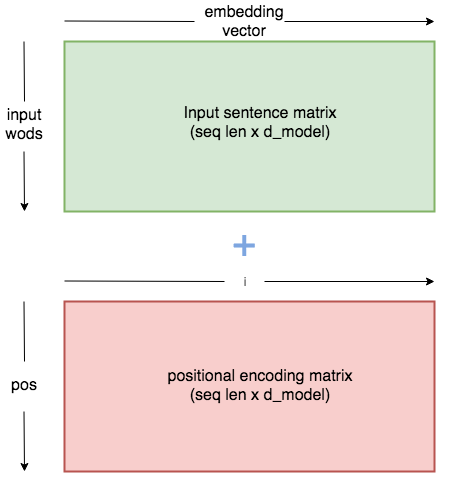

In [0]:
Image(filename='images/positional_encoding.png')

Figure comes from [How to code The Transformer in Pytorch](https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec#d554)

The goad of Positional encoding is to integrate the positional/sequential information into the sequence embeddings, so that the transformer can learn the ordering information correctly to generate sentences with correct order. 

In [0]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_len = MAX_LEN ):
        super().__init__()
        self.d_model = d_model  #d_model is the embedding dimension
        
        # initialize a PE matrix when creating the PositionalEncoder entity
        pe = torch.zeros( max_len, self.d_model )
        for pos in range( 0, max_len):
            for i in range( 0, self.d_model, 2 ):
                pe[pos, i ] = math.sin( pos/(10000**(i/self.d_model)) )
                if i+1 < self.d_model: 
                    pe[pos, i+1] = math.cos( pos/( 10000**(i/self.d_model ) ) )
        # register a buffer for the module, a buffer is not considered as a model parameter, so it it will not be loaded by model.parameters()
        # to access it, use: modudle_entity.buffer_name
        pe = pe.unsqueeze(0)  # now the shape becomes [1, max_len, d_model ]
        self.register_buffer("pe", pe)
        
    ## froward function takes a batch of word embeddings (x) [batch_size, seq_len, d_model], crop the pe matrix and add it to the embedding
    def forward( self, x ):
        # x is the embedding which is a wrapped up tensor, a variable. That's why here we 
        return x+Variable( self.pe[ :, :x.shape[1],:], requires_grad = False ).cuda()
        
        
    

In [0]:
#test
test_p_enc = PositionalEncoder( 6, 10 )
test_p_enc.pe

tensor([[[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
         [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
         [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
         [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
         [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
         [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
         [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
         [ 0.6570,  0.7539,  0.3192,  0.9477,  0.0151,  0.9999],
         [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999],
         [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998]]])

In [0]:
x= Variable( torch.ones(1,3,6) ).cuda()
test_p_enc(x)

tensor([[[1.0000, 2.0000, 1.0000, 2.0000, 1.0000, 2.0000],
         [1.8415, 1.5403, 1.0464, 1.9989, 1.0022, 2.0000],
         [1.9093, 0.5839, 1.0927, 1.9957, 1.0043, 2.0000]]], device='cuda:0')

Usually in a Module there will be some new Variables (trainable or not) being created. If there is just a serial of operations to existing tensors, then wrap them into a function. E.g. Maksing is actully a function.

### Masking: Padding Mask and Sequence Mask

The goal of padding mask is to make the Multi-Head-Attention (MHA) do not pay attention to the padding part of a sequence. Padding mask is used for both encoder and decoder. <br>
Sequence mask is only used by decoder. Since the decoder is expected to generate a sentence word by word. When generating current word, it only has the information of previously generated words. The purpose of sequence mask is to prevent the decoder from using future words. <br>

Mask module is applied after the dot product of Q and K, before applying softmax.

In [0]:
def atten_mask( x, pad_index, add_sequence_mask = False  ):
    ## x is a batch of sequences (not embedding) fetched from the dataset, suppose that its shape is [ batch_size, sequence_length ]
    seq_len = x.shape[1]
    mask =  x == pad_index
    mask =  mask.unsqueeze(1)#.repeat(1, seq_len, 1 )#,  don't add this repeat, otherwise the src_mask cannot applied to the context attention matrix
    if add_sequence_mask:
        seq_mask =  torch.Tensor(np.triu( np.ones(( seq_len, seq_len )) , k=1)).type( torch.uint8 ).cuda()
        mask = mask | seq_mask
    
    return mask

In [0]:
## test
x = torch.Tensor([[2,3,4,52,3,1],
                  [4,5,6,7,7,3]])
mask = atten_mask(  x,1, add_sequence_mask= False  )
mask

tensor([[[0, 0, 0, 0, 0, 1]],

        [[0, 0, 0, 0, 0, 0]]], dtype=torch.uint8)

### Multi Head Attention

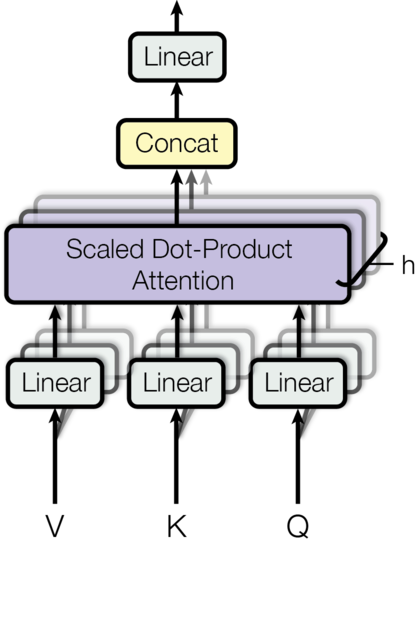

In [0]:
Image("images/MHA.png")

Figure comes from [How to code The Transformer in Pytorch](https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec#d554) and the original paper [Attention is all you need](https://arxiv.org/abs/1706.03762)

The key part is to compute the scaled dot-product attention. Note that there is no new Variables being created, only operation over existing Variables, so we use a function to describe it.

In [0]:
import torch.nn.functional as F

In [0]:
def scaled_dot_product_attention( q, k, v, d_k , mask= None ):
    # q shape [Batch_size , head_num , seq_len_q, d_q ]
    # k shape [Batch_size , head_num, seq_len_k, d_k  ]
    # v shape [Batch_size , head_num, seq_len_v, d_v ]
    # d_k = d_q 
    # Usually, d_k = d_q = d_v = d_model / head_num, where d_model is usally the word embedding dimension
    a = torch.matmul( q, k.transpose(-2,-1) )/math.sqrt(d_k)
    
    if mask is not None:
        ## mask is originally 3 dimension, that why here we need to first add one more dimension
        mask = mask.unsqueeze(1)
        a = a.masked_fill( mask, -np.Inf )

    ## if the last dimension there are all -np.Inf, the output will be nan. 
    ## But when running the model there is no cases where a whole row of the attention table a is masked, so we can use -np.Inf
    a = F.softmax(a, dim = -1 )
    output = torch.matmul( a, v )
    return output   
    

In [0]:
## test
q= torch.randn(2,2,3,3)
k= torch.randn(2,2,3,3)
v= torch.randn(2,2,3,3)
mask= torch.Tensor(np.triu( np.random.randn(2,3,3), k=1))!=0

In [0]:
scaled_dot_product_attention( q,k,v, k.shape[-1] , mask)

tensor([[[[ 1.3732, -0.7828,  1.0139],
          [ 0.9664, -0.8050,  1.0181],
          [ 0.4598, -0.5140,  1.1041]],

         [[-0.8896,  0.2838, -0.0869],
          [-0.8025,  0.3034, -0.5429],
          [-0.5304,  0.0723, -0.9016]]],


        [[[ 0.6805, -0.2969, -0.7366],
          [-0.1452,  0.6162, -0.5890],
          [-0.0111,  0.4010, -0.3879]],

         [[ 0.5277, -0.3647, -0.2432],
          [ 0.6919,  0.9350, -0.5890],
          [ 0.7394,  0.4775, -0.2833]]]])

Now it's the module for MultiHeadAttention

In [0]:
## define a naive initilize function for initialize for testing
## Note that in the weight of the linear module, the first dimension is the output dimension, while the second dimension is the input dimension.
def naive_init( linear_module ):
    linear_module.weight = torch.nn.Parameter(torch.ones(linear_module.weight.shape[0],linear_module.weight.shape[1] ))
    linear_module.bias = torch.nn.Parameter(torch.Tensor([0]).expand(linear_module.bias.shape[0]))

In [0]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_head, test_mode = False  ):
        super().__init__()
        self.d_model = d_model,
        self.num_head = num_head
        self.d_k = d_model // num_head
        
        self.linear_q = nn.Linear( d_model, self.d_k * num_head )
        self.linear_k = nn.Linear( d_model, self.d_k * num_head )
        self.linear_v = nn.Linear( d_model, self.d_k * num_head )
        
        self.linear_out = nn.Linear( self.d_k * num_head, d_model )
        
        if test_mode:
            naive_init( self.linear_q )
            naive_init( self.linear_k )
            naive_init( self.linear_v )
            naive_init( self.linear_out )
    
    def forward(self, q,k,v, mask = None ):
        q = self.linear_q(q)
        k = self.linear_k(k)
        v = self.linear_v(v)
        
        
        
        batch_size = q.shape[0]
        q = q.view( batch_size, -1, self.num_head, self.d_k  )
        k = k.view( batch_size, -1, self.num_head, self.d_k  )
        v = v.view( batch_size, -1, self.num_head, self.d_k  )
        
        
        # tranpose the matrix, to put the vectors in the same head together, note that here is transpose, not reshape
        """
            e.g:  before:  [ [1,2],[3,4] ], here 1 and 2 come from head 1 and head 2 separately. 3 and 4 come from head 1 and head 2
            reparately. If we want to put the elements of the same head together, we can use tranpose(0,1) to get
            [[1,3],[2,4]]
        """
        q = q.transpose(1,2)
        k = k.transpose(1,2)
        v = v.transpose(1,2)
        out = scaled_dot_product_attention( q, k, v, self.d_k , mask= mask )
        out = out.transpose( 1,2 ).contiguous().view( batch_size, -1, self.num_head * self.d_k )
        
        out = self.linear_out( out )
        
        return out
        

##### Why do we use the contiguous() function?

In [0]:
### 
"""
tensor.contiguous() will create a copy of the tensor, and the element in the copy will be stored in the memory in a contiguous way.
The contiguous() function is usually required when we first transpose() a tensor and then reshape (view) it. 
"""

aaa = torch.Tensor( [[1,2,3],[4,5,6]] )
print(aaa.stride())
print(aaa.is_contiguous())

(3, 1)
True


The stride() return (3,1) means that: when moving along the first dimension by each step (row by row), we need to move 3 steps in the memory. When moving along the second dimension (column by column), we need to move 1 step in the memory. This indicates that the elements in the tensor are stored contiguously.

In [0]:
bbb = aaa.transpose(0,1)
print(bbb.stride())
print(bbb.is_contiguous())

ccc = aaa.narrow(1,1,2)   ## equivalent to matrix slicing aaa[:,1:3]
print(ccc.stride())
print(ccc.is_contiguous())


ddd = aaa.repeat(2,1 )   # The first dimension repeat once, the second dimension repeat twice
print(ddd.stride())
print(ddd.is_contiguous())

## expand is different from repeat  if a tensor has a shape [d1,d2,1], it can only be expanded using "expand(d1,d2,d3)", which
## means the singleton dimension is repeated d3 times
eee = aaa.unsqueeze(2).expand(2,3,3)
print(eee.stride())
print(eee.is_contiguous())

fff = aaa.unsqueeze(2).repeat(1,1,8).view(2,-1,2)
print(fff.stride())
print(fff.is_contiguous())

(1, 3)
False
(3, 1)
False
(3, 1)
True
(3, 1, 0)
False
(24, 2, 1)
True


Ok, we can find that **transpose(), narrow() and tensor slicing, and expand()** will make the generated tensor not contiguous. Interestingly, repeat() and view() does not make it discontiguous. So now the question is: **what happens if I use a discontiguous tensor?**

The answer is it the view() function cannot be applied to a discontiguous tensor. This is probably because view() requires that the tensor to be contiguously stored so that it can do fast reshape in memory. e.g:

In [0]:
# bbb.view(-1,3)

To solve this, simply add contiguous() to a discontiguous tensor, to create contiguous copy and then apply view()

In [0]:
bbb.contiguous().view(-1,3)

tensor([[1., 4., 2.],
        [5., 3., 6.]])

####  test MHA

In [0]:
q= torch.randn(2,4,15)
k= torch.randn(2,4,15)
v= torch.randn(2,4,15)
mask= torch.Tensor(np.triu( np.random.randn(2,4,4), k=1))!=0

In [0]:
mha = MultiHeadAttention(15,3, test_mode = True)

atten = mha(q,k,v,mask)
atten

tensor([[[ 41.6856,  41.6856,  41.6856,  41.6856,  41.6856,  41.6856,  41.6856,
           41.6856,  41.6856,  41.6856,  41.6856,  41.6856,  41.6856,  41.6856,
           41.6856],
         [ -9.3566,  -9.3566,  -9.3566,  -9.3566,  -9.3566,  -9.3566,  -9.3566,
           -9.3566,  -9.3566,  -9.3566,  -9.3566,  -9.3566,  -9.3566,  -9.3566,
           -9.3566],
         [-28.2555, -28.2555, -28.2555, -28.2555, -28.2555, -28.2555, -28.2555,
          -28.2555, -28.2555, -28.2555, -28.2555, -28.2555, -28.2555, -28.2555,
          -28.2555],
         [  9.2964,   9.2964,   9.2964,   9.2964,   9.2964,   9.2964,   9.2964,
            9.2964,   9.2964,   9.2964,   9.2964,   9.2964,   9.2964,   9.2964,
            9.2964]],

        [[  2.8902,   2.8902,   2.8902,   2.8902,   2.8902,   2.8902,   2.8902,
            2.8902,   2.8902,   2.8902,   2.8902,   2.8902,   2.8902,   2.8902,
            2.8902],
         [  1.6232,   1.6232,   1.6232,   1.6232,   1.6232,   1.6232,   1.6232,
            1

### Feedforward Network

Feedforward network is a two-layer fully connected layers module, with the Relu activation in the hidden layer. The dimension of the hidden layer is 2048 by default.

In [0]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_hidden = 2048 , test_mode = False ):
        super().__init__()
        self.d_model = d_model
        self.d_hidden = d_hidden
        self.linear1 = nn.Linear( d_model, d_hidden )
        self.linear2 = nn.Linear( d_hidden, d_model )
        if test_mode:      
            naive_init(self.linear1 )
            naive_init(self.linear2 )
    
    def forward(self, x):
        net =  F.relu(self.linear1(x))
        out =  self.linear2(net)
        return out

In [0]:
## test
aaa = torch.randn(2,10)
fw = FeedForward( 10, 20,  test_mode= True )
fw(aaa)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<AddmmBackward>)

### With the modules above, we are now able to implement one layer of the Encoder, and one layer of Decoder

In [0]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_head, d_hidden=2048 ):
        super().__init__()

        
        self.multi_head_attention = MultiHeadAttention(d_model, num_head)
        self.norm1 = nn.LayerNorm( d_model )
        self.feed_forward = FeedForward( d_model, d_hidden )
        self.norm2 = nn.LayerNorm( d_model )
    
    def forward( self, x, mask  ):

        x1 = self.multi_head_attention( x, x, x, mask )
        x = self.norm1( x + x1 )
        
        x1 = self.feed_forward(x)
        x = self.norm2( x + x1 )
        
        return x

class DecoderLayer(nn.Module):
    def __init__( self,  d_model, num_head, d_hidden=2048 ):
        super().__init__()

        
        self.masked_multi_head_attention = MultiHeadAttention( d_model, num_head)
        self.norm1 = nn.LayerNorm( d_model )
        self.multi_head_attention = MultiHeadAttention( d_model, num_head )
        self.norm2 = nn.LayerNorm( d_model )
        self.feed_forward = FeedForward( d_model, d_hidden )
        self.norm3 = nn.LayerNorm( d_model )
    
    def forward(self, x, enc_out, src_mask, tgt_mask ):

        x1 = self.masked_multi_head_attention( x,x,x, tgt_mask )
        x = self.norm1( x + x1 )
        
        x1 = self.multi_head_attention( x, enc_out, enc_out,  src_mask )
        x = self.norm2( x + x1 )
        
        x1 = self.feed_forward( x )
        x = self.norm3( x + x1 )
        return x
        
        

In [0]:
# we define a module clone function

import copy
def get_clones(module, N):
    return nn.ModuleList( [copy.deepcopy(module) for _ in range(N)  ] )

### Then we have the Encoder and Decoder

In [0]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_head, N, max_len, d_hidden=2048  ):
        # N is the number of encoder layers
        super().__init__()
        
        self.word_embedding = nn.Embedding( vocab_size, d_model )
        self.pe = PositionalEncoder( d_model, max_len= max_len )
        self.encoder_layers = get_clones( EncoderLayer( d_model, num_head, d_hidden ), N )
        
    def forward(self, src, src_mask ):
        x = self.word_embedding( src )
        x = self.pe(x)
        for encoder_layer in self.encoder_layers:
            x = encoder_layer( x, src_mask )
        
        return x

## Note that we only use the last layer's output of the encoder, and send this enc_output to each layer of the decoder
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_head, N, max_len, d_hidden=2048 ):
        super().__init__()
        
        self.word_embedding = nn.Embedding( vocab_size, d_model )
        self.pe = PositionalEncoder( d_model, max_len )
        
        self.decoder_layers = get_clones( DecoderLayer(d_model, num_head, d_hidden ) , N )
        
        self.linear_out = nn.Linear( d_model, vocab_size )
        
        
    def forward( self, tgt, enc_output, src_mask, tgt_mask ):

        
        x = self.word_embedding( tgt )
        x = self.pe(x)
        for decoder_layer in self.decoder_layers:
            x = decoder_layer( x, enc_output, src_mask, tgt_mask )
        x = self.linear_out(x)
        return x
        

### And finally, the Transformer!

In [0]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size , src_pad_index, tgt_vocab_size, tgt_pad_index, d_model=512, num_head=8, N = 6, max_len=MAX_LEN, d_hidden = 2048 ):
        super().__init__()
        self.src_pad_index = src_pad_index
        self.tgt_pad_index = tgt_pad_index
        
        self.encoder = Encoder(src_vocab_size,  d_model, num_head, N, max_len, d_hidden  )
        self.decoder = Decoder(tgt_vocab_size,  d_model, num_head, N, max_len, d_hidden  )
    
    def forward(self, src, tgt):
        src_mask = atten_mask( src, self.src_pad_index, add_sequence_mask = False )
        tgt_mask = atten_mask( tgt, self.tgt_pad_index, add_sequence_mask = True  )
        
        enc_output = self.encoder(src, src_mask)
        dec_out = self.decoder( tgt, enc_output, src_mask, tgt_mask )
        
        return dec_out

In [0]:
def train( model, optim, epoch =0, num_epochs = 101, print_every = 100, device = device ):
    model.to(device)
    for epoch in range(epoch, num_epochs):
        running_loss = 0.0
        for i , data in enumerate( train_iter, 0 ):
            src_input = data.German.transpose(0,1).to(device)
            tgt = data.English.transpose(0,1)
            tgt_input = tgt[:, :-1].to(device)
            tgt_output = tgt[:, 1: ].contiguous().view(-1).to(device)
            
            # zero the parameters' gradients
            optim.zero_grad()
            # feed into the model
            outputs = model( src_input, tgt_input )
            # reshape the outputs' shape, to make it into the shape [ N, C ], where C is the number of classes
            outputs = outputs.view( -1, outputs.shape[-1] )
            # compute the loss, and ignore the gradients for target value = tgt_pad_index
            loss = F.cross_entropy( outputs, tgt_output, ignore_index = tgt_pad_index )
            loss.backward()
            optim.step()
            
            ## print loss statistics
            running_loss += loss.item()
            if i % print_every == print_every-1:
                print( '[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / print_every)) 
                running_loss = 0
        # save the model every 5 epochs
        if epoch % 5==4:
            torch.save({ "epoch":epoch, "model_state_dict":model.state_dict(), "optimizer_state_dict": optim.state_dict(), "loss":loss }, "./model.pt")
    
    print("End training!")

In [0]:
src_vocab_size = len(DE_Field.vocab)
src_pad_index = DE_Field.vocab.stoi["<pad>"]
tgt_vocab_size = len(EN_Field.vocab)
tgt_pad_index = EN_Field.vocab.stoi["<pad>"]
d_model = 512
num_head = 8
N = 6 
max_len = MAX_LEN
d_hidden = 2048

In [0]:
model = Transformer(  src_vocab_size , src_pad_index, tgt_vocab_size, tgt_pad_index, d_model = d_model , num_head = num_head , N = N , max_len = max_len , d_hidden = d_hidden  )
optim = torch.optim.Adam( model.parameters(), lr= 1e-3 )
epoch = 0
## Resume training
if os.path.exists("./model.pt"):
    ckpt = torch.load("./model.pt")
    model.load_state_dict( ckpt["model_state_dict"] )
    optim.load_state_dict( ckpt["optimizer_state_dict"])
    epoch = ckpt["epoch"]
    print("checkpoint loaded!")
    print(model.eval())

train(model, optim, epoch = epoch)




[1,   100] loss: 6.647
[1,   200] loss: 6.340
[1,   300] loss: 6.389
[1,   400] loss: 6.375
[1,   500] loss: 6.372
[1,   600] loss: 6.360
[1,   700] loss: 6.347
[1,   800] loss: 6.321
[1,   900] loss: 6.344
[1,  1000] loss: 6.305
[1,  1100] loss: 6.336
[1,  1200] loss: 6.328
[1,  1300] loss: 6.321
[1,  1400] loss: 6.316
[1,  1500] loss: 6.311
[1,  1600] loss: 6.341
[1,  1700] loss: 6.347
[1,  1800] loss: 6.322
[1,  1900] loss: 6.320
[1,  2000] loss: 6.339
[1,  2100] loss: 6.336
[1,  2200] loss: 6.314
[1,  2300] loss: 6.338
[1,  2400] loss: 6.328
[1,  2500] loss: 6.305
[1,  2600] loss: 6.311
[2,   100] loss: 6.293
[2,   200] loss: 6.319
[2,   300] loss: 6.279
[2,   400] loss: 6.305
[2,   500] loss: 6.335
[2,   600] loss: 6.321
[2,   700] loss: 6.332
[2,   800] loss: 6.306
[2,   900] loss: 6.288
[2,  1000] loss: 6.321
[2,  1100] loss: 6.310
[2,  1200] loss: 6.306
[2,  1300] loss: 6.294
[2,  1400] loss: 6.283
[2,  1500] loss: 6.273
[2,  1600] loss: 6.276
[2,  1700] loss: 6.310
[2,  1800] 

In [0]:
!nvidia-smi

In [0]:
! top

### This is a small sample of writting self defined Dataset 

In [0]:
!python -m spacy download de

In [0]:
"""
This file is mainly used for text preprocessing
"""
import re
import unicodedata
import numpy as np

DATA_PATH = "data/de-en/europarl-v7.de-en."
MAX_LENGTH = 10


## first define the vocabulary class, which is used to contain the word2index, index2word, word2count, n_word
class Vocab:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.index2word = { 0:"SOS", 1:"EOS" }  # SOS start of sentence, EOS end of sentence
        self.word2count = {}
        self.num_words = 2
    
    ## This input sentence is assumed to be clean!
    def add_sentence(self, sentence ):
        for word in sentence.split(" "):
            self.add_word( word )

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.index2word[self.num_words] = word
            self.word2count[word] = 1
            self.num_words +=1
        else:
            self.word2count[word] +=1




# fh = open("data/de-en/europarl-v7.de-en.en")
# input_lang = "de"
# output_lang = "en"

# pairs, input_vocab, output_vocab = load_sentence_pairs(input_lang,output_lang )

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CorpusDataset(Dataset):
    ## functions used to clean each line. customized
    def unicode_to_ascii(self, s):
        return "".join( [c for c in unicodedata.normalize("NFD", s)  if unicodedata.category(c) != "Mn" ]   )

    def clean_string(self, s):
        s = self.unicode_to_ascii(s)
        s = s.lower().strip()
        ## add space before and after the punctuation . ? !
        s = re.sub( r"([.!?])", r" \1", s )
        s = re.sub( r"[^a-zA-Z.?!]", r" ", s )
        return s
    
    ## above are customized functions for tokenization

    def __init__( self, input_lang, output_lang, data_path = DATA_PATH , transform = None, ):
        self.input_vocab = Vocab(input_lang)
        self.output_vocab = Vocab(output_lang)
        self.transform = transform
        
        ## load sentence pairs into memory
        f_input = open( data_path+input_lang, "r" ).readlines()
        f_output = open( data_path+output_lang, "r" ).readlines()
        assert len(f_input)==len(f_output)
        idx =0
        self.pairs=[]
        ## clean and tokenize the input data and store them into the vocabulary and training pairs
        for idx in range(len(f_input)):
            ## filter out some long sentences to reduce the data size
            if len( f_input[idx].split(" ") )<MAX_LENGTH and len(f_output[idx].split(" ") )<MAX_LENGTH :
                
                clean_input_sentence = self.clean_string( f_input[idx] )
                clean_output_sentence = self.clean_string( f_output[idx] ) 
                self.input_vocab.add_sentence(clean_input_sentence)
                self.output_vocab.add_sentence(clean_output_sentence)
                
                input_seq = [  self.input_vocab.word2index[w] for w in clean_input_sentence.split(" ")  ]
                output_seq = [ self.output_vocab.word2index[w] for w in clean_output_sentence.split(" ") ]
                
                self.pairs.append(  [input_seq,output_seq  ] )

            if idx % 10000 == 999:
                print("\r current progress: %.2f%%"%( idx/len(f_input)*100 ), end="", flush=True)
        
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        
        input_seq = np.array(self.pairs[idx][0])
        output_seq =np.array(self.pairs[idx][1])
        
        sample = {"input": input_seq, "output": output_seq  }
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

class ToTensor(object):
    """convert ndarrays into Tensors"""
    def __call__( self, sample ):
        input_seq, output_seq = sample["input"], sample["output"]
        
        return {"input": torch.from_numpy( input_seq ), "output": torch.from_numpy( output_seq )  }    

data = CorpusDataset("de", "en", transform= transforms.Compose([ToTensor()]) )    
for i in range(len(data)):
    sample = data[i]
    print(sample["input"], sample["output"])
    if i ==10:
        break

dataloader = DataLoader( data, batch_size = 5, shuffle = True, num_workers =10  )
iter(dataloader).next()